In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
def perform_norm(type, num_channels, channel_size_w, channel_size_h, num_groups=2):
    if type == 'BN':
        return nn.BatchNorm2d(num_channels)
    elif type == 'LN':
        return nn.LayerNorm((num_channels, channel_size_w, channel_size_h))
    elif type == 'GN':
        return nn.GroupNorm(num_groups, num_channels)


In [49]:
class Net(nn.Module):
    def __init__(self, type):
        super(Net, self).__init__()
        dropout_prob=0.1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 12, 3, padding=1, bias=False),
            nn.ReLU(),
            perform_norm(type, 12, 28, 28, 2),
            nn.Dropout2d(p=dropout_prob)
        ) # Input=28, Output=28, rf=3
        self.conv2 = nn.Sequential(
            nn.Conv2d(12, 12, 3, padding=1, bias=False),
            nn.ReLU(),
            perform_norm(type, 12, 28, 28, 2),
            nn.Dropout2d(p=dropout_prob)
        ) # Input=28, Output=28, rf=5

        self.pool1= nn.MaxPool2d(2, 2) # Input=28, Output=14, rf=6

        self.conv3 = nn.Sequential(
            nn.Conv2d(12, 14, 3, padding=1, bias=False),
            nn.ReLU(),
            perform_norm(type, 14, 14, 14, 2),
            nn.Dropout2d(p=dropout_prob) # Input=14, Output=14, rf=10
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(14, 14, 3, padding=1, bias=False),
            nn.ReLU(),
            perform_norm(type, 14, 14, 14, 2),
            nn.Dropout2d(p=dropout_prob) # Input=14, Output=14, rf=14
        )

        self.pool2= nn.MaxPool2d(2, 2) # Input=14, Output=7, rf=16

        self.conv5 = nn.Sequential(
            nn.Conv2d(14, 14, 3, padding=0, bias=False),
            nn.ReLU(),
            perform_norm(type, 14, 5, 5, 2),
            nn.Dropout2d(p=dropout_prob) # Input=7, Output=5, rf=24
        )
       
        self.conv6 = nn.Sequential(
            nn.Conv2d(14, 10, 3, padding=0, bias=False),
        ) # Input=5, Output=3, rf=32

        self.global_avgpool = nn.AdaptiveAvgPool2d(1)  # Input=3, Output=1, rf=40
      
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.pool2(x)
        x = self.conv5(x)
        x = self.conv6(x)
               
        x = self.global_avgpool(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [42]:
from tqdm import tqdm


def train(model, device, train_loader, optimizer, epoch, train_loss_list, train_acc_list, l1_param=0.0):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_losses = []
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    if l1_param > 0.0:
        regularization_loss = 0.0

        for param in model.parameters():
            if param.dim() > 1 :
                regularization_loss += param.norm(1)

        regularization_loss *= l1_param
        loss += regularization_loss     
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc_list.append(100*correct/processed)
  train_loss_list.append(sum(train_losses)/len(train_losses))

def test(model, device, test_loader, test_loss_list, test_acc_list):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_loss_list.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_list.append(100. * correct / len(test_loader.dataset))

Misclassified Images

In [43]:

def find_plot_misclassified_images(test_loader, model, num_display_images = 20):
    incorrect_image_list =[]
    predicted_label_list =[]
    correct_label_list = []
    for (i, [data, target]) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True).squeeze(1)         
        idxs_mask = (pred !=  target).view(-1)
        img_nm = data[idxs_mask].cpu().numpy()
        img_nm = img_nm.reshape(img_nm.shape[0], 28, 28)
        if img_nm.shape[0] > 0:
            img_list = [img_nm[i] for i in range(img_nm.shape[0])]
            incorrect_image_list.extend(img_list)
            predicted_label_list.extend(pred[idxs_mask].cpu().numpy())
            correct_label_list.extend(target[idxs_mask].cpu().numpy())

    plt.figure(figsize=(15,15))
    columns = 5
    i= 0
    # Display the list of 25 misclassified images
    for index, image in enumerate(incorrect_image_list) :
        ax = plt.subplot(5, 5, i+1)
        ax.set_title("Actual: " + str(correct_label_list[index]) + ", Predicted: " + str(predicted_label_list[index]))
        ax.axis('off')
        plt.imshow(image)
        i +=1
        if i== num_display_images:
            break

In [44]:
batch_size = 64
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),

                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

Group Normalization + L1

In [45]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_groupnorm_l1 = Net('GN').to(device)
summary(model_groupnorm_l1, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 28, 28]             108
              ReLU-2           [-1, 12, 28, 28]               0
         GroupNorm-3           [-1, 12, 28, 28]              24
         Dropout2d-4           [-1, 12, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,728
              ReLU-6           [-1, 16, 28, 28]               0
         GroupNorm-7           [-1, 16, 28, 28]              32
         Dropout2d-8           [-1, 16, 28, 28]               0
         MaxPool2d-9           [-1, 16, 14, 14]               0
           Conv2d-10           [-1, 16, 14, 14]           2,304
             ReLU-11           [-1, 16, 14, 14]               0
        GroupNorm-12           [-1, 16, 14, 14]              32
        Dropout2d-13           [-1, 16, 14, 14]               0
           Conv2d-14           [-1, 16,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [58]:

from torch.optim.lr_scheduler import StepLR

model_groupnorm_l1 =  Net('GN').to(device)
optimizer = optim.SGD(model_groupnorm_l1.parameters(), lr=0.19, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 25
train_loss_groupnorm_l1_list = []
train_acc_groupnorm_l1_list = []
test_loss_groupnorm_l1_list = []
test_acc_groupnorm_l1_list = []
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model_groupnorm_l1, device, train_loader, optimizer, epoch, train_loss_groupnorm_l1_list, train_acc_groupnorm_l1_list, l1_param= 0.0005 )
    test(model_groupnorm_l1, device, test_loader, test_loss_groupnorm_l1_list, test_acc_groupnorm_l1_list )
    scheduler.step()

  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=2.445645570755005 Batch_id=1 Accuracy=13.28:   0%|          | 1/938 [00:00<01:36,  9.66it/s]

EPOCH: 1


Loss=0.6778039932250977 Batch_id=937 Accuracy=86.48: 100%|██████████| 938/938 [01:19<00:00, 11.81it/s]
Loss=0.4318804144859314 Batch_id=1 Accuracy=96.09:   0%|          | 2/938 [00:00<01:14, 12.49it/s]


Test set: Average loss: 0.1522, Accuracy: 9546/10000 (95.46%)

EPOCH: 2


Loss=0.4916514456272125 Batch_id=937 Accuracy=92.86: 100%|██████████| 938/938 [01:19<00:00, 11.79it/s]
Loss=0.5522448420524597 Batch_id=1 Accuracy=92.97:   0%|          | 2/938 [00:00<01:16, 12.26it/s]


Test set: Average loss: 0.1012, Accuracy: 9662/10000 (96.62%)

EPOCH: 3


Loss=0.4641232490539551 Batch_id=937 Accuracy=93.43: 100%|██████████| 938/938 [01:20<00:00, 11.60it/s]
Loss=0.436599463224411 Batch_id=1 Accuracy=92.19:   0%|          | 2/938 [00:00<01:22, 11.40it/s]


Test set: Average loss: 0.0948, Accuracy: 9705/10000 (97.05%)

EPOCH: 4


Loss=0.7795044779777527 Batch_id=937 Accuracy=93.49: 100%|██████████| 938/938 [01:20<00:00, 11.67it/s]
Loss=0.5318825244903564 Batch_id=1 Accuracy=91.41:   0%|          | 2/938 [00:00<01:17, 12.12it/s]


Test set: Average loss: 0.1257, Accuracy: 9592/10000 (95.92%)

EPOCH: 5


Loss=0.5184307098388672 Batch_id=937 Accuracy=93.55: 100%|██████████| 938/938 [01:20<00:00, 11.69it/s]
Loss=0.7042302489280701 Batch_id=1 Accuracy=90.62:   0%|          | 2/938 [00:00<01:19, 11.79it/s]


Test set: Average loss: 0.1019, Accuracy: 9664/10000 (96.64%)

EPOCH: 6


Loss=0.959284782409668 Batch_id=937 Accuracy=93.64: 100%|██████████| 938/938 [01:20<00:00, 11.64it/s]
Loss=0.46660804748535156 Batch_id=1 Accuracy=90.62:   0%|          | 2/938 [00:00<01:17, 12.08it/s]


Test set: Average loss: 0.0921, Accuracy: 9710/10000 (97.10%)

EPOCH: 7


Loss=0.25128990411758423 Batch_id=937 Accuracy=96.50: 100%|██████████| 938/938 [01:20<00:00, 11.59it/s]
Loss=0.34168487787246704 Batch_id=1 Accuracy=97.66:   0%|          | 2/938 [00:00<01:19, 11.76it/s]


Test set: Average loss: 0.0523, Accuracy: 9831/10000 (98.31%)

EPOCH: 8


Loss=0.3673160970211029 Batch_id=937 Accuracy=96.63: 100%|██████████| 938/938 [01:20<00:00, 11.72it/s]
Loss=0.29360049962997437 Batch_id=1 Accuracy=96.88:   0%|          | 2/938 [00:00<01:17, 12.04it/s]


Test set: Average loss: 0.0508, Accuracy: 9857/10000 (98.57%)

EPOCH: 9


Loss=0.2300243228673935 Batch_id=937 Accuracy=96.63: 100%|██████████| 938/938 [01:20<00:00, 11.64it/s]
Loss=0.24206700921058655 Batch_id=1 Accuracy=95.31:   0%|          | 2/938 [00:00<01:18, 11.98it/s]


Test set: Average loss: 0.0551, Accuracy: 9822/10000 (98.22%)

EPOCH: 10


Loss=0.2833297550678253 Batch_id=937 Accuracy=96.49: 100%|██████████| 938/938 [01:21<00:00, 11.57it/s]
Loss=0.22069217264652252 Batch_id=1 Accuracy=96.09:   0%|          | 2/938 [00:00<01:15, 12.40it/s]


Test set: Average loss: 0.0557, Accuracy: 9827/10000 (98.27%)

EPOCH: 11


Loss=0.24164554476737976 Batch_id=937 Accuracy=96.38: 100%|██████████| 938/938 [01:20<00:00, 11.65it/s]
Loss=0.24579954147338867 Batch_id=1 Accuracy=96.88:   0%|          | 2/938 [00:00<01:16, 12.17it/s]


Test set: Average loss: 0.0545, Accuracy: 9829/10000 (98.29%)

EPOCH: 12


Loss=0.21150118112564087 Batch_id=937 Accuracy=96.41: 100%|██████████| 938/938 [01:19<00:00, 11.73it/s]
Loss=0.3103104829788208 Batch_id=1 Accuracy=96.09:   0%|          | 2/938 [00:00<01:18, 11.89it/s]


Test set: Average loss: 0.0532, Accuracy: 9833/10000 (98.33%)

EPOCH: 13


Loss=0.1627729833126068 Batch_id=937 Accuracy=97.04: 100%|██████████| 938/938 [01:20<00:00, 11.67it/s]
Loss=0.1844974309206009 Batch_id=1 Accuracy=97.66:   0%|          | 2/938 [00:00<01:20, 11.60it/s]


Test set: Average loss: 0.0452, Accuracy: 9855/10000 (98.55%)

EPOCH: 14


Loss=0.18954595923423767 Batch_id=937 Accuracy=97.23: 100%|██████████| 938/938 [01:20<00:00, 11.68it/s]
Loss=0.23012304306030273 Batch_id=1 Accuracy=95.31:   0%|          | 2/938 [00:00<01:16, 12.27it/s]


Test set: Average loss: 0.0443, Accuracy: 9858/10000 (98.58%)

EPOCH: 15


Loss=0.27302950620651245 Batch_id=937 Accuracy=97.28: 100%|██████████| 938/938 [01:19<00:00, 11.78it/s]
Loss=0.2163516879081726 Batch_id=1 Accuracy=96.88:   0%|          | 2/938 [00:00<01:16, 12.28it/s]


Test set: Average loss: 0.0433, Accuracy: 9866/10000 (98.66%)

EPOCH: 16


Loss=0.12676867842674255 Batch_id=937 Accuracy=97.25: 100%|██████████| 938/938 [01:19<00:00, 11.79it/s]
Loss=0.1322043538093567 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:18, 11.90it/s]


Test set: Average loss: 0.0436, Accuracy: 9864/10000 (98.64%)

EPOCH: 17


Loss=0.18007320165634155 Batch_id=937 Accuracy=97.24: 100%|██████████| 938/938 [01:20<00:00, 11.59it/s]
Loss=0.16951759159564972 Batch_id=1 Accuracy=96.88:   0%|          | 2/938 [00:00<01:16, 12.17it/s]


Test set: Average loss: 0.0432, Accuracy: 9862/10000 (98.62%)

EPOCH: 18


Loss=0.14620527625083923 Batch_id=937 Accuracy=97.22: 100%|██████████| 938/938 [01:20<00:00, 11.67it/s]
Loss=0.18069815635681152 Batch_id=1 Accuracy=97.66:   0%|          | 2/938 [00:00<01:20, 11.68it/s]


Test set: Average loss: 0.0424, Accuracy: 9859/10000 (98.59%)

EPOCH: 19


Loss=0.17035546898841858 Batch_id=937 Accuracy=97.32: 100%|██████████| 938/938 [01:20<00:00, 11.69it/s]
Loss=0.12184788286685944 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:15, 12.34it/s]


Test set: Average loss: 0.0422, Accuracy: 9865/10000 (98.65%)

EPOCH: 20


Loss=0.16517023742198944 Batch_id=937 Accuracy=97.46: 100%|██████████| 938/938 [01:20<00:00, 11.66it/s]
Loss=0.13180461525917053 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:21, 11.55it/s]


Test set: Average loss: 0.0421, Accuracy: 9862/10000 (98.62%)

EPOCH: 21


Loss=0.2715149521827698 Batch_id=937 Accuracy=97.41: 100%|██████████| 938/938 [01:20<00:00, 11.60it/s]
Loss=0.12806999683380127 Batch_id=1 Accuracy=97.66:   0%|          | 2/938 [00:00<01:17, 12.04it/s]


Test set: Average loss: 0.0421, Accuracy: 9866/10000 (98.66%)

EPOCH: 22


Loss=0.11507955193519592 Batch_id=937 Accuracy=97.34: 100%|██████████| 938/938 [01:20<00:00, 11.63it/s]
Loss=0.18498310446739197 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:22, 11.36it/s]


Test set: Average loss: 0.0420, Accuracy: 9868/10000 (98.68%)

EPOCH: 23


Loss=0.3002491593360901 Batch_id=937 Accuracy=97.31: 100%|██████████| 938/938 [01:20<00:00, 11.70it/s]
Loss=0.20898258686065674 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:20, 11.60it/s]


Test set: Average loss: 0.0419, Accuracy: 9867/10000 (98.67%)

EPOCH: 24


Loss=0.1364428997039795 Batch_id=937 Accuracy=97.46: 100%|██████████| 938/938 [01:20<00:00, 11.66it/s]
Loss=0.16636723279953003 Batch_id=1 Accuracy=96.09:   0%|          | 2/938 [00:00<01:19, 11.70it/s]


Test set: Average loss: 0.0421, Accuracy: 9866/10000 (98.66%)

EPOCH: 25


Loss=0.1650698482990265 Batch_id=937 Accuracy=97.43: 100%|██████████| 938/938 [01:19<00:00, 11.77it/s]



Test set: Average loss: 0.0420, Accuracy: 9867/10000 (98.67%)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


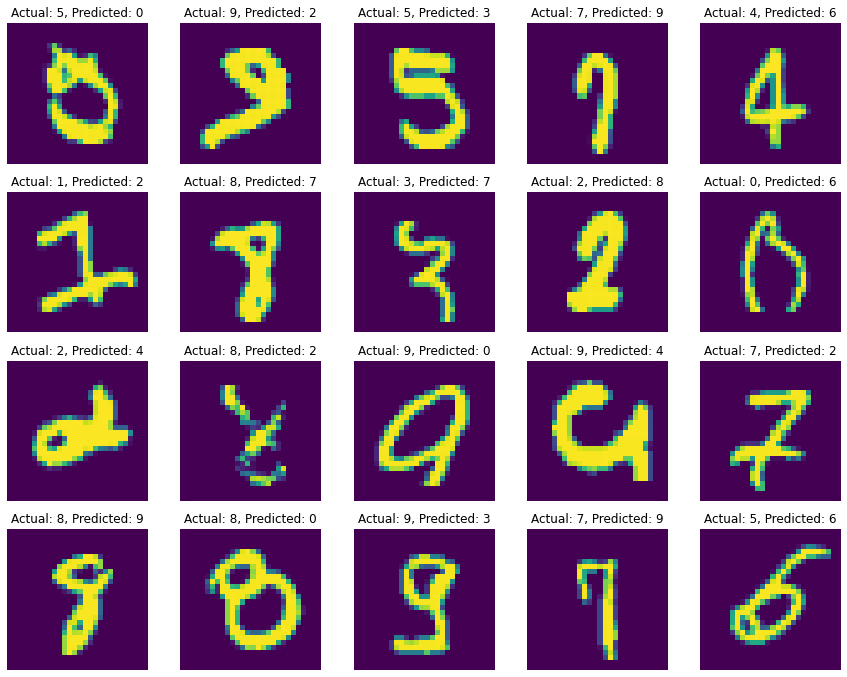

In [47]:
find_plot_misclassified_images(test_loader, model_groupnorm_l1)

Ananlysis


* The group normalization and L1 regularization reduced the model accuracy to 98.66%, 
  

*  But the test accuracy is greater than Training accuracy.

# Layer Normalization + L2 

* The Layer normalization should add more parameters to the network, hence it should be computationally expensive. Let's observe

In [50]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_layernorm_l2 = Net('LN').to(device)
summary(model_layernorm_l2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 28, 28]             108
              ReLU-2           [-1, 12, 28, 28]               0
         LayerNorm-3           [-1, 12, 28, 28]          18,816
         Dropout2d-4           [-1, 12, 28, 28]               0
            Conv2d-5           [-1, 12, 28, 28]           1,296
              ReLU-6           [-1, 12, 28, 28]               0
         LayerNorm-7           [-1, 12, 28, 28]          18,816
         Dropout2d-8           [-1, 12, 28, 28]               0
         MaxPool2d-9           [-1, 12, 14, 14]               0
           Conv2d-10           [-1, 14, 14, 14]           1,512
             ReLU-11           [-1, 14, 14, 14]               0
        LayerNorm-12           [-1, 14, 14, 14]           5,488
        Dropout2d-13           [-1, 14, 14, 14]               0
           Conv2d-14           [-1, 14,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [51]:
model_layernorm_l2 =  Net('LN').to(device)
optimizer = optim.SGD(model_layernorm_l2.parameters(), lr=0.19, momentum=0.9,  weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 25
train_loss_layernorm_l2_list = []
train_acc_layernorm_l2_list = []
test_loss_layernorm_l2_list = []
test_acc_layernorm_l2_list = []
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model_layernorm_l2, device, train_loader, optimizer, epoch, train_loss_layernorm_l2_list, train_acc_layernorm_l2_list )
    test(model_layernorm_l2, device, test_loader, test_loss_layernorm_l2_list, test_acc_layernorm_l2_list)
    scheduler.step()

  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=2.4590141773223877 Batch_id=1 Accuracy=14.84:   0%|          | 2/938 [00:00<01:26, 10.78it/s]

EPOCH: 1


Loss=0.15041647851467133 Batch_id=937 Accuracy=87.47: 100%|██████████| 938/938 [01:19<00:00, 11.80it/s]
Loss=0.13255742192268372 Batch_id=1 Accuracy=94.53:   0%|          | 2/938 [00:00<01:20, 11.67it/s]


Test set: Average loss: 0.0973, Accuracy: 9724/10000 (97.24%)

EPOCH: 2


Loss=0.10984928160905838 Batch_id=937 Accuracy=94.28: 100%|██████████| 938/938 [01:20<00:00, 11.66it/s]
Loss=0.18875226378440857 Batch_id=1 Accuracy=93.75:   0%|          | 2/938 [00:00<01:20, 11.67it/s]


Test set: Average loss: 0.1298, Accuracy: 9592/10000 (95.92%)

EPOCH: 3


Loss=0.1435028612613678 Batch_id=937 Accuracy=94.34: 100%|██████████| 938/938 [01:20<00:00, 11.64it/s]
Loss=0.17303353548049927 Batch_id=1 Accuracy=94.53:   0%|          | 2/938 [00:00<01:16, 12.21it/s]


Test set: Average loss: 0.1075, Accuracy: 9681/10000 (96.81%)

EPOCH: 4


Loss=0.08618658035993576 Batch_id=937 Accuracy=94.38: 100%|██████████| 938/938 [01:19<00:00, 11.76it/s]
Loss=0.14238862693309784 Batch_id=1 Accuracy=89.84:   0%|          | 2/938 [00:00<01:19, 11.79it/s]


Test set: Average loss: 0.1118, Accuracy: 9643/10000 (96.43%)

EPOCH: 5


Loss=0.3393368422985077 Batch_id=937 Accuracy=94.39: 100%|██████████| 938/938 [01:19<00:00, 11.77it/s]
Loss=0.21682539582252502 Batch_id=1 Accuracy=94.53:   0%|          | 2/938 [00:00<01:21, 11.55it/s]


Test set: Average loss: 0.1285, Accuracy: 9596/10000 (95.96%)

EPOCH: 6


Loss=0.18248562514781952 Batch_id=937 Accuracy=94.44: 100%|██████████| 938/938 [01:20<00:00, 11.69it/s]
Loss=0.2318120151758194 Batch_id=1 Accuracy=96.09:   0%|          | 2/938 [00:00<01:17, 12.13it/s]


Test set: Average loss: 0.1230, Accuracy: 9630/10000 (96.30%)

EPOCH: 7


Loss=0.07061098515987396 Batch_id=937 Accuracy=97.17: 100%|██████████| 938/938 [01:22<00:00, 11.41it/s]
Loss=0.09542013704776764 Batch_id=1 Accuracy=96.88:   0%|          | 2/938 [00:00<01:19, 11.78it/s]


Test set: Average loss: 0.0488, Accuracy: 9861/10000 (98.61%)

EPOCH: 8


Loss=0.03092682734131813 Batch_id=937 Accuracy=97.69: 100%|██████████| 938/938 [01:22<00:00, 11.42it/s]
Loss=0.11069803684949875 Batch_id=1 Accuracy=96.88:   0%|          | 2/938 [00:00<01:19, 11.84it/s]


Test set: Average loss: 0.0480, Accuracy: 9863/10000 (98.63%)

EPOCH: 9


Loss=0.11884834617376328 Batch_id=937 Accuracy=97.85: 100%|██████████| 938/938 [01:23<00:00, 11.20it/s]
Loss=0.034083954989910126 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:23, 11.25it/s]


Test set: Average loss: 0.0460, Accuracy: 9867/10000 (98.67%)

EPOCH: 10


Loss=0.11813367158174515 Batch_id=937 Accuracy=97.72: 100%|██████████| 938/938 [01:24<00:00, 11.13it/s]
Loss=0.08392443507909775 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:21, 11.55it/s]


Test set: Average loss: 0.0497, Accuracy: 9863/10000 (98.63%)

EPOCH: 11


Loss=0.07964236289262772 Batch_id=937 Accuracy=97.64: 100%|██████████| 938/938 [01:21<00:00, 11.46it/s]
Loss=0.042890515178442 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:18, 11.86it/s]


Test set: Average loss: 0.0486, Accuracy: 9856/10000 (98.56%)

EPOCH: 12


Loss=0.013672737404704094 Batch_id=937 Accuracy=97.69: 100%|██████████| 938/938 [01:22<00:00, 11.33it/s]
Loss=0.1010052040219307 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:24, 11.11it/s]


Test set: Average loss: 0.0500, Accuracy: 9848/10000 (98.48%)

EPOCH: 13


Loss=0.014287428930401802 Batch_id=937 Accuracy=98.27: 100%|██████████| 938/938 [01:21<00:00, 11.50it/s]
Loss=0.031820084899663925 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:21, 11.43it/s]


Test set: Average loss: 0.0343, Accuracy: 9892/10000 (98.92%)

EPOCH: 14


Loss=0.04449058324098587 Batch_id=937 Accuracy=98.53: 100%|██████████| 938/938 [01:21<00:00, 11.50it/s]
Loss=0.07611031830310822 Batch_id=1 Accuracy=97.66:   0%|          | 2/938 [00:00<01:15, 12.37it/s]


Test set: Average loss: 0.0320, Accuracy: 9889/10000 (98.89%)

EPOCH: 15


Loss=0.039945416152477264 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [01:20<00:00, 11.68it/s]
Loss=0.016629638150334358 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:17, 12.03it/s]


Test set: Average loss: 0.0300, Accuracy: 9901/10000 (99.01%)

EPOCH: 16


Loss=0.020183321088552475 Batch_id=937 Accuracy=98.60: 100%|██████████| 938/938 [01:19<00:00, 11.79it/s]
Loss=0.018957100808620453 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:21, 11.46it/s]


Test set: Average loss: 0.0299, Accuracy: 9897/10000 (98.97%)

EPOCH: 17


Loss=0.0315035916864872 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [01:19<00:00, 11.80it/s]
Loss=0.03241395205259323 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:20, 11.56it/s]


Test set: Average loss: 0.0289, Accuracy: 9906/10000 (99.06%)

EPOCH: 18


Loss=0.011125150136649609 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [01:19<00:00, 11.80it/s]
Loss=0.10362136363983154 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:16, 12.20it/s]


Test set: Average loss: 0.0290, Accuracy: 9905/10000 (99.05%)

EPOCH: 19


Loss=0.035450976341962814 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [01:19<00:00, 11.78it/s]
Loss=0.022094503045082092 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:22, 11.40it/s]


Test set: Average loss: 0.0276, Accuracy: 9914/10000 (99.14%)

EPOCH: 20


Loss=0.018276216462254524 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [01:20<00:00, 11.72it/s]
Loss=0.07188492268323898 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:21, 11.55it/s]


Test set: Average loss: 0.0274, Accuracy: 9912/10000 (99.12%)

EPOCH: 21


Loss=0.113954558968544 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [01:20<00:00, 11.64it/s]
Loss=0.020706580951809883 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:18, 11.86it/s]


Test set: Average loss: 0.0271, Accuracy: 9914/10000 (99.14%)

EPOCH: 22


Loss=0.01781339757144451 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [01:19<00:00, 11.80it/s]
Loss=0.0673845186829567 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:21, 11.43it/s]


Test set: Average loss: 0.0269, Accuracy: 9913/10000 (99.13%)

EPOCH: 23


Loss=0.011486670933663845 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [01:20<00:00, 11.71it/s]
Loss=0.05292060598731041 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:16, 12.21it/s]


Test set: Average loss: 0.0269, Accuracy: 9915/10000 (99.15%)

EPOCH: 24


Loss=0.18243061006069183 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [01:20<00:00, 11.70it/s]
Loss=0.03141341730952263 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:24, 11.01it/s]


Test set: Average loss: 0.0267, Accuracy: 9917/10000 (99.17%)

EPOCH: 25


Loss=0.015662746503949165 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [01:19<00:00, 11.73it/s]



Test set: Average loss: 0.0267, Accuracy: 9917/10000 (99.17%)



# Aanalysis

* The Layer normalization and L2 regularization improved the accuracy to 99.19%

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


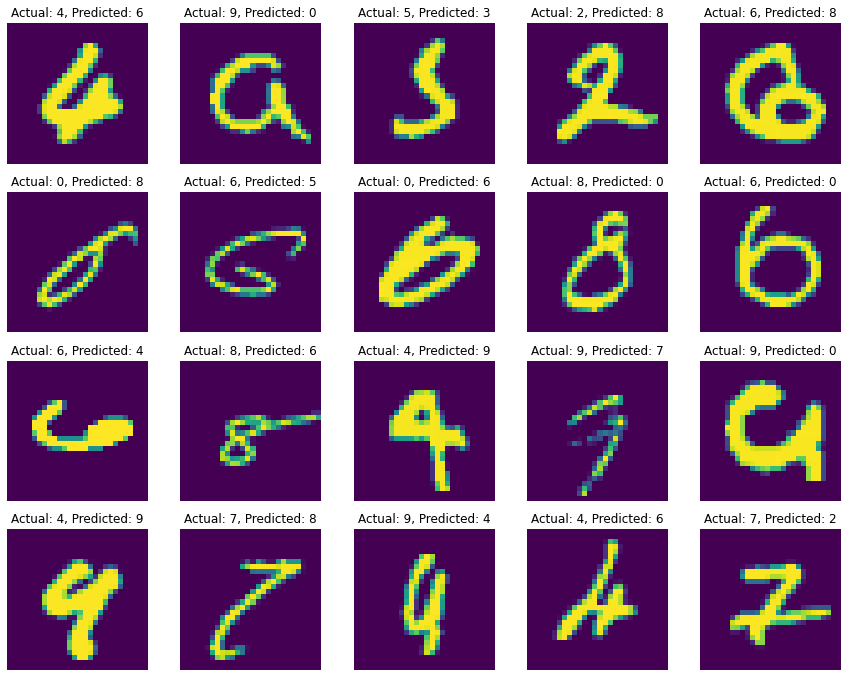

In [52]:
find_plot_misclassified_images(test_loader, model_layernorm_l2)

# Batch Normalization L1 + L2

* The below code has been designed to include the our own Batch Normalization with both L1 & L2 regularization



In [53]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_batchnorm_l1_l2 = Net('BN').to(device)
summary(model_batchnorm_l1_l2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 28, 28]             108
              ReLU-2           [-1, 12, 28, 28]               0
       BatchNorm2d-3           [-1, 12, 28, 28]              24
         Dropout2d-4           [-1, 12, 28, 28]               0
            Conv2d-5           [-1, 12, 28, 28]           1,296
              ReLU-6           [-1, 12, 28, 28]               0
       BatchNorm2d-7           [-1, 12, 28, 28]              24
         Dropout2d-8           [-1, 12, 28, 28]               0
         MaxPool2d-9           [-1, 12, 14, 14]               0
           Conv2d-10           [-1, 14, 14, 14]           1,512
             ReLU-11           [-1, 14, 14, 14]               0
      BatchNorm2d-12           [-1, 14, 14, 14]              28
        Dropout2d-13           [-1, 14, 14, 14]               0
           Conv2d-14           [-1, 14,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [54]:
model_layernorm_l2 =  Net('BN').to(device)
optimizer = optim.SGD(model_layernorm_l2.parameters(), lr=0.19, momentum=0.9,  weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 25
train_loss_batchnorm_l1_l2_list = []
train_acc_batchnorm_l1_l2_list = []
test_loss_batchnorm_l1_l2_list = []
test_acc_batchnorm_l1_l2_list = []
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model_layernorm_l2, device, train_loader, optimizer, epoch, train_loss_batchnorm_l1_l2_list, train_acc_batchnorm_l1_l2_list, l1_param= 0.0005 )
    test(model_layernorm_l2, device, test_loader, test_loss_batchnorm_l1_l2_list, test_acc_batchnorm_l1_l2_list)
    scheduler.step()

  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=2.4937376976013184 Batch_id=1 Accuracy=11.72:   0%|          | 1/938 [00:00<01:36,  9.70it/s]

EPOCH: 1


Loss=0.405132532119751 Batch_id=937 Accuracy=90.89: 100%|██████████| 938/938 [01:28<00:00, 10.59it/s]
Loss=0.5707768797874451 Batch_id=1 Accuracy=90.62:   0%|          | 2/938 [00:00<01:26, 10.80it/s]


Test set: Average loss: 0.1362, Accuracy: 9562/10000 (95.62%)

EPOCH: 2


Loss=0.5548650622367859 Batch_id=937 Accuracy=93.28: 100%|██████████| 938/938 [01:28<00:00, 10.55it/s]
Loss=0.6204773187637329 Batch_id=1 Accuracy=92.97:   0%|          | 1/938 [00:00<01:36,  9.71it/s]


Test set: Average loss: 0.1132, Accuracy: 9685/10000 (96.85%)

EPOCH: 3


Loss=0.5075289011001587 Batch_id=937 Accuracy=93.57: 100%|██████████| 938/938 [01:28<00:00, 10.58it/s]
Loss=0.44807159900665283 Batch_id=1 Accuracy=92.19:   0%|          | 2/938 [00:00<01:28, 10.60it/s]


Test set: Average loss: 0.2020, Accuracy: 9348/10000 (93.48%)

EPOCH: 4


Loss=0.5396201014518738 Batch_id=937 Accuracy=93.41: 100%|██████████| 938/938 [01:29<00:00, 10.49it/s]
Loss=0.4463557004928589 Batch_id=1 Accuracy=96.09:   0%|          | 2/938 [00:00<01:27, 10.67it/s]


Test set: Average loss: 0.0913, Accuracy: 9719/10000 (97.19%)

EPOCH: 5


Loss=0.6361565589904785 Batch_id=937 Accuracy=93.45: 100%|██████████| 938/938 [01:28<00:00, 10.56it/s]
Loss=0.44521355628967285 Batch_id=1 Accuracy=93.75:   0%|          | 2/938 [00:00<01:27, 10.65it/s]


Test set: Average loss: 0.0870, Accuracy: 9736/10000 (97.36%)

EPOCH: 6


Loss=0.6015712022781372 Batch_id=937 Accuracy=93.36: 100%|██████████| 938/938 [01:28<00:00, 10.65it/s]
Loss=0.45313501358032227 Batch_id=1 Accuracy=94.53:   0%|          | 2/938 [00:00<01:25, 10.94it/s]


Test set: Average loss: 0.1033, Accuracy: 9660/10000 (96.60%)

EPOCH: 7


Loss=0.2587040960788727 Batch_id=937 Accuracy=97.06: 100%|██████████| 938/938 [01:27<00:00, 10.72it/s]
Loss=0.26593711972236633 Batch_id=1 Accuracy=96.88:   0%|          | 2/938 [00:00<01:26, 10.78it/s]


Test set: Average loss: 0.0463, Accuracy: 9860/10000 (98.60%)

EPOCH: 8


Loss=0.19029763340950012 Batch_id=937 Accuracy=97.14: 100%|██████████| 938/938 [01:28<00:00, 10.61it/s]
Loss=0.20404765009880066 Batch_id=1 Accuracy=97.66:   0%|          | 2/938 [00:00<01:27, 10.64it/s]


Test set: Average loss: 0.0660, Accuracy: 9804/10000 (98.04%)

EPOCH: 9


Loss=0.3224867582321167 Batch_id=937 Accuracy=96.92: 100%|██████████| 938/938 [01:28<00:00, 10.63it/s]
Loss=0.22820648550987244 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:25, 10.91it/s]


Test set: Average loss: 0.0485, Accuracy: 9855/10000 (98.55%)

EPOCH: 10


Loss=0.17678509652614594 Batch_id=937 Accuracy=96.86: 100%|██████████| 938/938 [01:28<00:00, 10.65it/s]
Loss=0.21299520134925842 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:26, 10.87it/s]


Test set: Average loss: 0.0556, Accuracy: 9836/10000 (98.36%)

EPOCH: 11


Loss=0.21567735075950623 Batch_id=937 Accuracy=96.78: 100%|██████████| 938/938 [01:27<00:00, 10.67it/s]
Loss=0.2454339563846588 Batch_id=1 Accuracy=98.44:   0%|          | 1/938 [00:00<01:33,  9.99it/s] 


Test set: Average loss: 0.0554, Accuracy: 9832/10000 (98.32%)

EPOCH: 12


Loss=0.21532641351222992 Batch_id=937 Accuracy=96.91: 100%|██████████| 938/938 [01:27<00:00, 10.68it/s]
Loss=0.25024062395095825 Batch_id=1 Accuracy=93.75:   0%|          | 2/938 [00:00<01:25, 10.93it/s]


Test set: Average loss: 0.0553, Accuracy: 9834/10000 (98.34%)

EPOCH: 13


Loss=0.2311910092830658 Batch_id=937 Accuracy=97.89: 100%|██████████| 938/938 [01:27<00:00, 10.68it/s]
Loss=0.20870107412338257 Batch_id=1 Accuracy=97.66:   0%|          | 2/938 [00:00<01:25, 10.89it/s]


Test set: Average loss: 0.0326, Accuracy: 9887/10000 (98.87%)

EPOCH: 14


Loss=0.1486407369375229 Batch_id=937 Accuracy=97.99: 100%|██████████| 938/938 [01:28<00:00, 10.59it/s]
Loss=0.15614770352840424 Batch_id=1 Accuracy=96.88:   0%|          | 2/938 [00:00<01:28, 10.63it/s]


Test set: Average loss: 0.0321, Accuracy: 9895/10000 (98.95%)

EPOCH: 15


Loss=0.12429779022932053 Batch_id=937 Accuracy=98.05: 100%|██████████| 938/938 [01:28<00:00, 10.55it/s]
Loss=0.17097538709640503 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:25, 10.90it/s]


Test set: Average loss: 0.0353, Accuracy: 9890/10000 (98.90%)

EPOCH: 16


Loss=0.1254633069038391 Batch_id=937 Accuracy=98.13: 100%|██████████| 938/938 [01:28<00:00, 10.54it/s]
Loss=0.16440436244010925 Batch_id=1 Accuracy=97.66:   0%|          | 2/938 [00:00<01:26, 10.76it/s]


Test set: Average loss: 0.0313, Accuracy: 9899/10000 (98.99%)

EPOCH: 17


Loss=0.3247750997543335 Batch_id=937 Accuracy=98.01: 100%|██████████| 938/938 [01:29<00:00, 10.52it/s]
Loss=0.12142439186573029 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:26, 10.79it/s]


Test set: Average loss: 0.0326, Accuracy: 9892/10000 (98.92%)

EPOCH: 18


Loss=0.13654570281505585 Batch_id=937 Accuracy=97.97: 100%|██████████| 938/938 [01:28<00:00, 10.55it/s]
Loss=0.14567555487155914 Batch_id=1 Accuracy=96.88:   0%|          | 2/938 [00:00<01:27, 10.75it/s]


Test set: Average loss: 0.0344, Accuracy: 9891/10000 (98.91%)

EPOCH: 19


Loss=0.1395324468612671 Batch_id=937 Accuracy=98.19: 100%|██████████| 938/938 [01:28<00:00, 10.64it/s]
Loss=0.1743178516626358 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:23, 11.27it/s]


Test set: Average loss: 0.0296, Accuracy: 9903/10000 (99.03%)

EPOCH: 20


Loss=0.4263039231300354 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [01:27<00:00, 10.67it/s]
Loss=0.118135005235672 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:24, 11.02it/s]


Test set: Average loss: 0.0273, Accuracy: 9904/10000 (99.04%)

EPOCH: 21


Loss=0.21988503634929657 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [01:31<00:00, 10.24it/s]
Loss=0.17829826474189758 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:28, 10.60it/s]


Test set: Average loss: 0.0272, Accuracy: 9902/10000 (99.02%)

EPOCH: 22


Loss=0.12863501906394958 Batch_id=937 Accuracy=98.26: 100%|██████████| 938/938 [01:30<00:00, 10.35it/s]
Loss=0.09516644477844238 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:40,  9.33it/s]


Test set: Average loss: 0.0274, Accuracy: 9908/10000 (99.08%)

EPOCH: 23


Loss=0.10630889236927032 Batch_id=937 Accuracy=98.31: 100%|██████████| 938/938 [01:30<00:00, 10.33it/s]
Loss=0.15829196572303772 Batch_id=1 Accuracy=97.66:   0%|          | 2/938 [00:00<01:28, 10.61it/s]


Test set: Average loss: 0.0278, Accuracy: 9911/10000 (99.11%)

EPOCH: 24


Loss=0.13819727301597595 Batch_id=937 Accuracy=98.25: 100%|██████████| 938/938 [01:30<00:00, 10.34it/s]
Loss=0.1524536907672882 Batch_id=1 Accuracy=96.88:   0%|          | 2/938 [00:00<01:30, 10.36it/s]


Test set: Average loss: 0.0283, Accuracy: 9907/10000 (99.07%)

EPOCH: 25


Loss=0.11245587468147278 Batch_id=937 Accuracy=98.37: 100%|██████████| 938/938 [01:30<00:00, 10.42it/s]



Test set: Average loss: 0.0273, Accuracy: 9910/10000 (99.10%)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


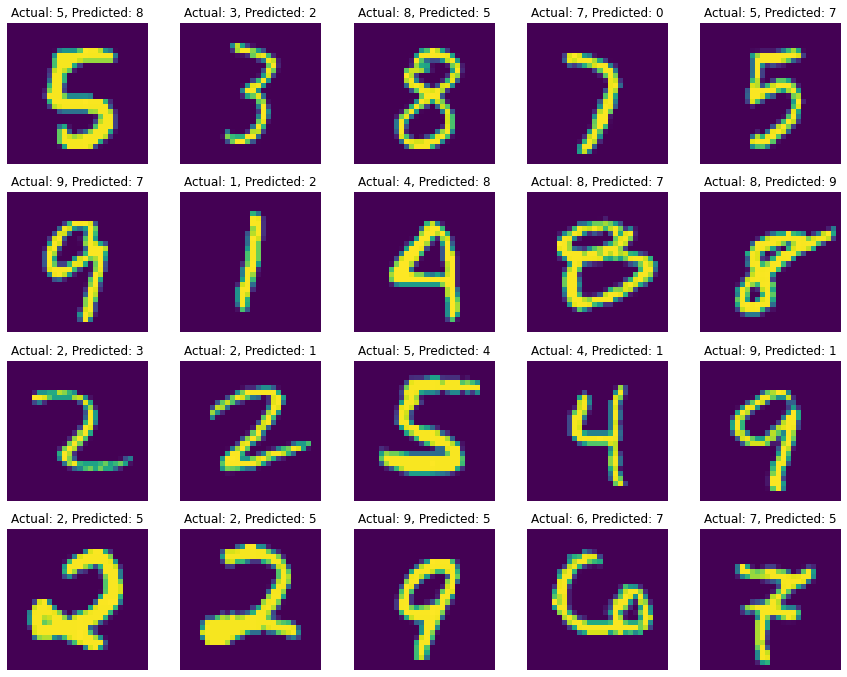

In [55]:
find_plot_misclassified_images(test_loader, model_batchnorm_l1_l2)

# Tain/Test Loss and Accuracy Plots for all the three models¶


In [56]:
import matplotlib.pyplot as plt
def plot_train_loss(train_loss_groupnorm_l1_list, train_loss_layernorm_l2_list, train_loss_batchnorm_l1_l2_list):
    fig, axs = plt.subplots(figsize=(5,5))
    axs.plot(train_loss_groupnorm_l1_list, label="Group Normalization + L1 Train Loss")
    axs.plot(train_loss_layernorm_l2_list, label="Layer Normalization + L2 Train Loss")
    axs.plot(train_loss_batchnorm_l1_l2_list, label="Batch Normalization + L1 + L2 Train Loss")
    axs.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

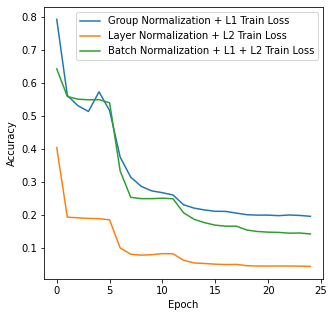

In [57]:
plot_train_loss(train_loss_groupnorm_l1_list, train_loss_layernorm_l2_list, train_loss_batchnorm_l1_l2_list)

# Analysis

* Group Normalization + L1 the loss started high and remained high after 20 epochs
* Layer Normalization + L2 the loss started lower than the above and remained lower as well after 20 epochs
* Finally the Batch Normalization + L1 + L2 the loss started lowest and ended lowest as well



In [60]:

def plot_test_accuracy(test_acc_groupnorm_l1_list, test_acc_layernorm_l2_list, test_acc_batchnorm_l1_l2_list):
    fig, axs = plt.subplots(figsize=(5,5))
    axs.plot(test_acc_groupnorm_l1_list, label="Group Normalization + L1 Test Accuracy")
    axs.plot(test_acc_layernorm_l2_list, label="Layer Normalization + L2 Test Accuracy")
    axs.plot(test_acc_batchnorm_l1_l2_list, label="Batch Normalization + L1 + L2 Test Accuracy")
    axs.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

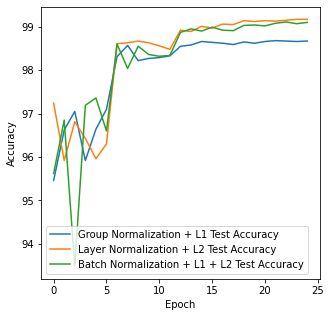

In [61]:
plot_test_accuracy(test_acc_groupnorm_l1_list, test_acc_layernorm_l2_list, test_acc_batchnorm_l1_l2_list)

# Test Accuracy Observation

* Layer Normalization + L2 the loss attained a better accuracy than the others while Group Normalization + L1 was the lowest
* However as discussed before the reason could be the increase in number of parameters
* Here with this study we will not infer anything rather wait for the next phase of study

